In [50]:
## Library
from pyspark.sql import SparkSession
from pyspark import SparkFiles
from pyspark.sql.functions import col
from pyspark.sql.types import *
import pandas as pd
import matplotlib.pyplot as plt

# For Data Frame
from pyspark.sql.functions import col, to_date, date_format, lit,expr
import random

#For Figures
import matplotlib.pyplot as plt  #Plot
import pyspark.sql.functions as F  #SQL
from pyspark.sql.window import Window
import numpy as np
import pandas as pd
import textwrap
from pandas.plotting import register_matplotlib_converters
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum as sum_
from pyspark.sql.functions import col

import matplotlib.dates as mdates
from pyspark.sql.functions import to_date, date_trunc, col   # Date
import seaborn as sns

In [51]:
from pyspark.sql import SparkSession
from pyspark.ml.stat import Correlation
import pyspark.sql.functions as F
from pyspark.ml.feature import StringIndexer, OneHotEncoder

In [52]:
# Make Spark Session, Data Frame, Read Data
spark = SparkSession.builder \
.master("local") \
.appName("abappy") \
.getOrCreate()

df = spark.read.csv('/mnt/group-14-pvc/processed_data', header = True, inferSchema = True)

df.show(vertical=False)
df.printSchema()
#df.show(5)
print("total data:")
df.count()

root
 |-- supermarket: string (nullable = true)
 |-- price: double (nullable = true)
 |-- price_unit: double (nullable = true)
 |-- measure_unit: string (nullable = true)
 |-- product_name: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- product_category: string (nullable = true)
 |-- own_brand: boolean (nullable = true)
 |-- city: string (nullable = true)

total data:


2104337

In [53]:
from pyspark.sql import functions as F
from pyspark.sql import Window

# 1. Calculate basic statistics: min, max, mean
basic_stats = df.agg(
    F.min("price").alias("min_price"),
    F.max("price").alias("max_price"),
    F.mean("price").alias("mean_price"),
)
basic_stats.show()

# 2. Calculate median
median_approx = df.approxQuantile("price", [0.5], 0.001)[0]
print(f"Approximate Median of price: {median_approx}")

# 3. Calculate mode
mode = (
    df.groupBy("price")
    .count()
    .orderBy(F.desc("count"), F.desc("price"))
    .first()
    .price
)
print(f"Mode of price: {mode}")

# 4. Display all statistics
print("Summary:")
summary = df.describe("price")
summary.show()

+---------+---------+-----------------+
|min_price|max_price|       mean_price|
+---------+---------+-----------------+
|     0.01|   479.99|5.229516222478307|
+---------+---------+-----------------+

Approximate Median of price: 2.99
Mode of price: 2.0
Summary:
+-------+-----------------+
|summary|            price|
+-------+-----------------+
|  count|          2104335|
|   mean|5.229516222478307|
| stddev|7.561511411885447|
|    min|             0.01|
|    max|           479.99|
+-------+-----------------+



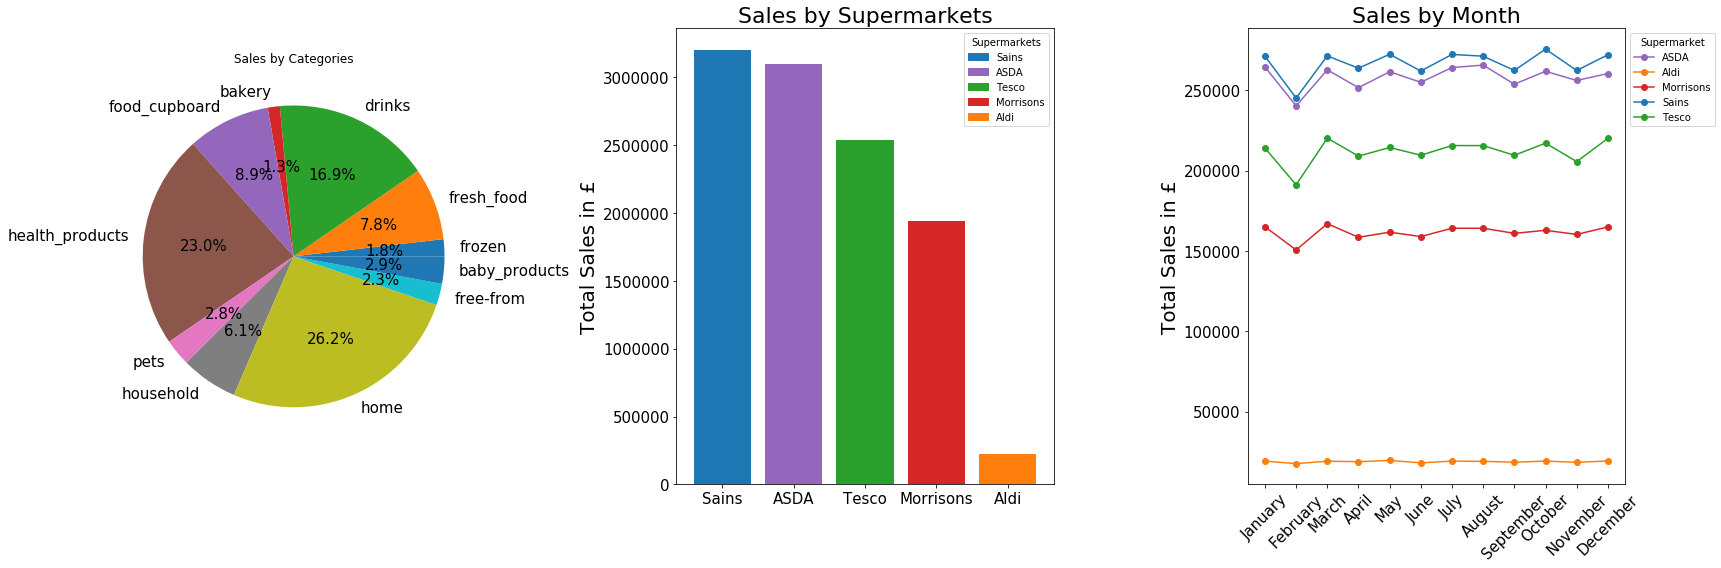

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import functions as F
from pyspark.sql.functions import to_date, date_trunc

# Assuming 'df' is your PySpark DataFrame

# Setup the figure
fig, axs = plt.subplots(1, 3, figsize=(24, 8))  # 1 row, 3 columns

# Define a consistent color map for supermarkets
supermarkets = df.select("supermarket").distinct().rdd.flatMap(lambda x: x).collect()
colors = plt.get_cmap('tab10')  # This colormap has 10 colors, adjust if you have more supermarkets
color_dict = {supermarket: colors(i) for i, supermarket in enumerate(supermarkets)}

# Plot 1: Sales Distribution by Product Category (Pie Chart)
sales_by_category = df.groupBy("product_category").agg(F.sum("price").alias("total_sales"))
sales_by_category_pd = sales_by_category.toPandas()
axs[0].pie(sales_by_category_pd['total_sales'], labels=sales_by_category_pd['product_category'], autopct='%3.1f%%', textprops={'fontsize': 15})
axs[0].set_title('Sales by Categories')

# Plot 2: Total Sales by Supermarket (sorted)
sales_by_supermarket = df.groupby("supermarket").agg(F.sum("price").alias("total_sales"))
sales_pd = sales_by_supermarket.toPandas().sort_values(by="total_sales", ascending=False)
sorted_supermarkets = sales_pd['supermarket']
sales_pd['color'] = sales_pd['supermarket'].apply(lambda x: color_dict[x])
axs[1].bar(sales_pd["supermarket"], sales_pd["total_sales"], color=sales_pd['color'], align='center')
axs[1].set_ylabel("Total Sales in £", fontsize=20)
axs[1].set_title("Sales by Supermarkets", fontsize=22)
axs[1].tick_params(axis='x', labelsize=15, rotation=0)
axs[1].tick_params(axis='y', labelsize=15)
handles = [plt.Rectangle((0, 0), 1, 1, color=color_dict[supermarket]) for supermarket in sorted_supermarkets]
axs[1].legend(handles, sorted_supermarkets, title="Supermarkets")

# Plot 3: Total Sales Over Time by Supermarket
df = df.withColumn("date", to_date(df.date, "yyyy-MM-dd"))
df = df.withColumn("month", date_trunc("month", df.date))
sales_by_supermarket_month = df.groupby("supermarket", "month").agg(F.sum("price").alias("total_sales")).orderBy("supermarket", "month")
sales_pd = sales_by_supermarket_month.toPandas()
sales_pd['month_name'] = sales_pd['month'].dt.strftime('%B')
sales_pd['color'] = sales_pd['supermarket'].apply(lambda x: color_dict[x])
supermarkets = sales_pd['supermarket'].unique()

for supermarket in supermarkets:
    df_filtered = sales_pd[sales_pd['supermarket'] == supermarket]
    axs[2].plot(df_filtered["month_name"], df_filtered["total_sales"], marker='o', linestyle='-', label=supermarket, color=color_dict[supermarket])

axs[2].set_ylabel("Total Sales in £", fontsize=20)
axs[2].set_title("Sales by Month", fontsize=22)
axs[2].tick_params(axis='x', labelsize=15, rotation=45)
axs[2].tick_params(axis='y', labelsize=15)
axs[2].legend(title="Supermarket", loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()


In [5]:
from pyspark.sql.functions import to_date, date_trunc

# Assuming 'df' is your PySpark DataFrame

# Print Sales Distribution by Product Category
sales_by_category = df.groupBy("product_category").agg(F.sum("price").alias("total_sales"))
sales_by_category_pd = sales_by_category.toPandas()
print("Sales Distribution by Product Category:")
print(sales_by_category_pd)
print("\n")

# Print Total Sales by Supermarket
sales_by_supermarket = df.groupby("supermarket").agg(F.sum("price").alias("total_sales")).orderBy("total_sales", ascending=False)
sales_by_supermarket_pd = sales_by_supermarket.toPandas()
print("Total Sales by Supermarket:")
print(sales_by_supermarket_pd)
print("\n")

# Print Total Sales Over Time by Supermarket
df = df.withColumn("date", to_date(df.date, "yyyy-MM-dd"))
df = df.withColumn("month", date_trunc("month", df.date))
sales_by_supermarket_month = df.groupby("supermarket", "month").agg(F.sum("price").alias("total_sales")).orderBy("supermarket", "month")
sales_by_supermarket_month_pd = sales_by_supermarket_month.toPandas()
sales_by_supermarket_month_pd['month_name'] = sales_by_supermarket_month_pd['month'].dt.strftime('%B')
print("Total Sales Over Time by Supermarket:")
print(sales_by_supermarket_month_pd[['supermarket', 'month_name', 'total_sales']])
print("\n")

Sales Distribution by Product Category:
   product_category   total_sales
0            frozen  2.008252e+05
1        fresh_food  8.554106e+05
2            drinks  1.855674e+06
3            bakery  1.423938e+05
4     food_cupboard  9.750414e+05
5   health_products  2.526759e+06
6              pets  3.133146e+05
7         household  6.723362e+05
8              home  2.888502e+06
9         free-from  2.528239e+05
10    baby_products  3.215740e+05


Total Sales by Supermarket:
  supermarket   total_sales
0       Sains  3.200942e+06
1        ASDA  3.096774e+06
2       Tesco  2.541240e+06
3   Morrisons  1.938782e+06
4        Aldi  2.269155e+05


Total Sales Over Time by Supermarket:
   supermarket month_name  total_sales
0         ASDA    January    264433.92
1         ASDA   February    240264.54
2         ASDA      March    262644.24
3         ASDA      April    251555.05
4         ASDA        May    261456.80
5         ASDA       June    254899.64
6         ASDA       July    264080.88
7 

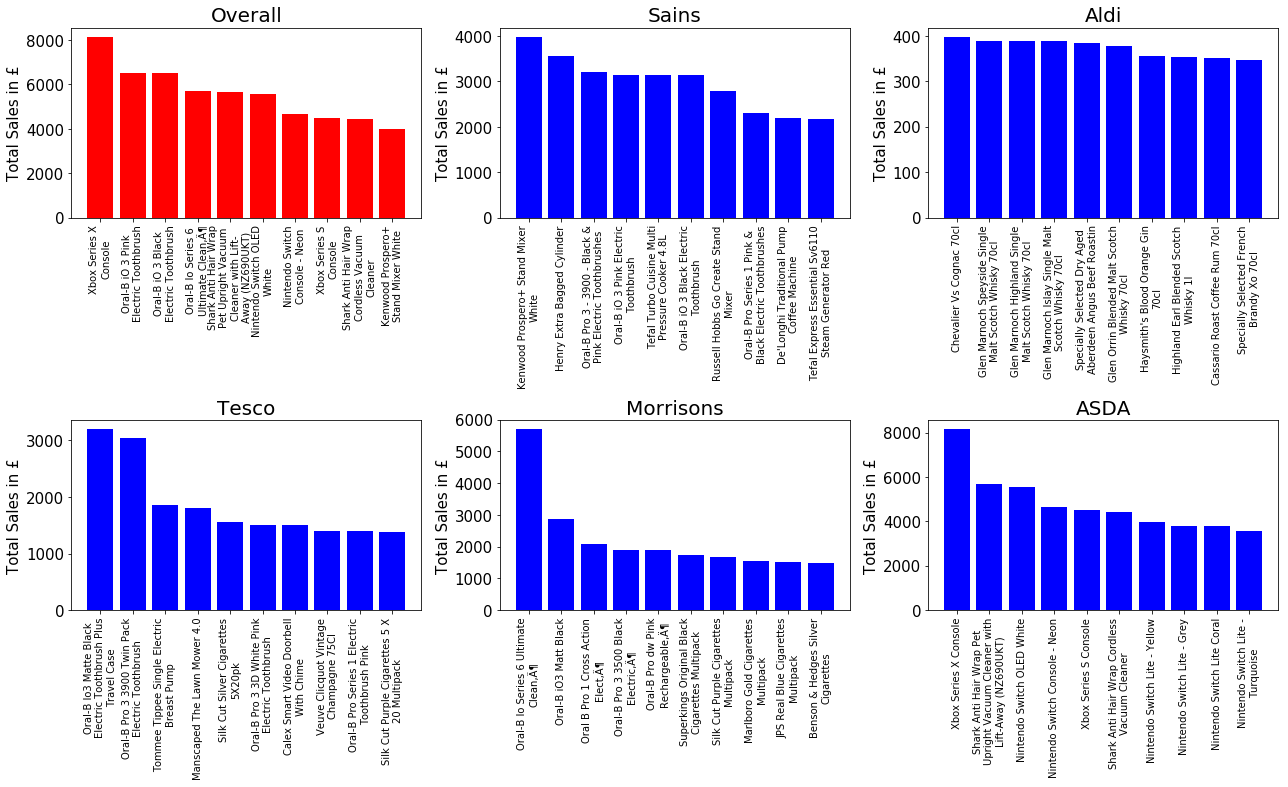

In [12]:
## top product names all 
import matplotlib.pyplot as plt
import pandas as pd
import textwrap
from pyspark.sql.functions import sum as sum_, col

def split_name(name, width=20):
    """Splits a name into multiple lines if longer than width."""
    return '\n'.join(textwrap.wrap(name, width))

# Assuming 'df' is your Spark DataFrame containing the necessary data

# Calculate total sales per product across all supermarkets
total_sales_per_product = df.groupBy("product_name") \
                             .agg(sum_("price").alias("total_sales")) \
                             .orderBy(col("total_sales").desc())

# Get top 10 selling products globally
top_10_global_products = total_sales_per_product.limit(10)
top_10_global_products_pd = top_10_global_products.toPandas()
top_10_global_products_pd['product_name'] = top_10_global_products_pd['product_name'].apply(lambda x: split_name(x, width=20))

# Get top 10 selling products for each supermarket
supermarkets = df.select("supermarket").distinct().rdd.flatMap(lambda x: x).collect()
supermarket_sales_data = {}

for supermarket in supermarkets:
    top_10_products = df.filter(df.supermarket == supermarket) \
                        .groupBy("product_name") \
                        .agg(sum_("price").alias("total_sales")) \
                        .orderBy(col("total_sales").desc()).limit(10)
    supermarket_sales_data[supermarket] = top_10_products.toPandas()
    supermarket_sales_data[supermarket]['product_name'] = supermarket_sales_data[supermarket]['product_name'].apply(lambda x: split_name(x, width=30))

# Set up the matplotlib figure and axes for the subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))  # Adjust layout size accordingly

# Plot the overall top 10 in the first subplot
ax_global = axes[0,0]
ax_global.bar(top_10_global_products_pd["product_name"], top_10_global_products_pd["total_sales"], color='red', align='center')  # Use red for differentiation
ax_global.set_title("Overall", fontsize=20)
ax_global.set_ylabel("Total Sales in £", fontsize=15)
ax_global.tick_params(axis='x', rotation=90, labelsize=10)
ax_global.tick_params(axis='y', labelsize=15)

# Plot top 10 for each supermarket in other subplots
for i, (supermarket, data) in enumerate(supermarket_sales_data.items(), start=1):
    row = (i // 3)
    col = (i % 3)
    ax = axes[row, col]
    ax.bar(data["product_name"], data["total_sales"], color='blue', align='center')
    ax.set_title(supermarket, fontsize=20)
    ax.set_ylabel("Total Sales in £", fontsize=15)
    ax.tick_params(axis='x', rotation=90, labelsize=10)
    ax.tick_params(axis='y', labelsize=15)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title
plt.show()


In [10]:
from pyspark.sql.functions import sum as sum_, col

# Calculate total sales per product across all supermarkets
total_sales_per_product = df.groupBy("product_name") \
                             .agg(sum_("price").alias("total_sales")) \
                             .orderBy(col("total_sales").desc())

# Get top 10 selling products globally
top_10_global_products = total_sales_per_product.limit(10)
top_10_global_products_pd = top_10_global_products.toPandas()
print("Top 10 Selling Products Globally:")
print(top_10_global_products_pd)
print("\n")

# Get top 10 selling products for each supermarket
supermarkets = df.select("supermarket").distinct().rdd.flatMap(lambda x: x).collect()
supermarket_sales_data = {}

for supermarket in supermarkets:
    top_10_products = df.filter(df.supermarket == supermarket) \
                        .groupBy("product_name") \
                        .agg(sum_("price").alias("total_sales")) \
                        .orderBy(col("total_sales").desc()).limit(10)
    supermarket_sales_data[supermarket] = top_10_products.toPandas()
    print(f"Top 10 Selling Products in {supermarket}:")
    print(supermarket_sales_data[supermarket])
    print("\n")


Top 10 Selling Products Globally:
                                        product_name  total_sales
0                              Xbox Series X Console      8159.83
1               Oral-B iO 3 Pink Electric Toothbrush      6510.00
2              Oral-B iO 3 Black Electric Toothbrush      6510.00
3               Oral-B Io Series 6 Ultimate Clean‚Ä¶      5700.00
4  Shark Anti Hair Wrap Pet Upright Vacuum Cleane...      5669.79
5                         Nintendo Switch OLED White      5562.00
6                     Nintendo Switch Console - Neon      4662.00
7                              Xbox Series S Console      4499.82
8       Shark Anti Hair Wrap Cordless Vacuum Cleaner      4431.88
9                Kenwood Prospero+ Stand Mixer White      3990.00


Top 10 Selling Products in Sains:
                                        product_name  total_sales
0                Kenwood Prospero+ Stand Mixer White       3990.0
1                        Henry Extra Bagged Cylinder       3570.0
2  Ora

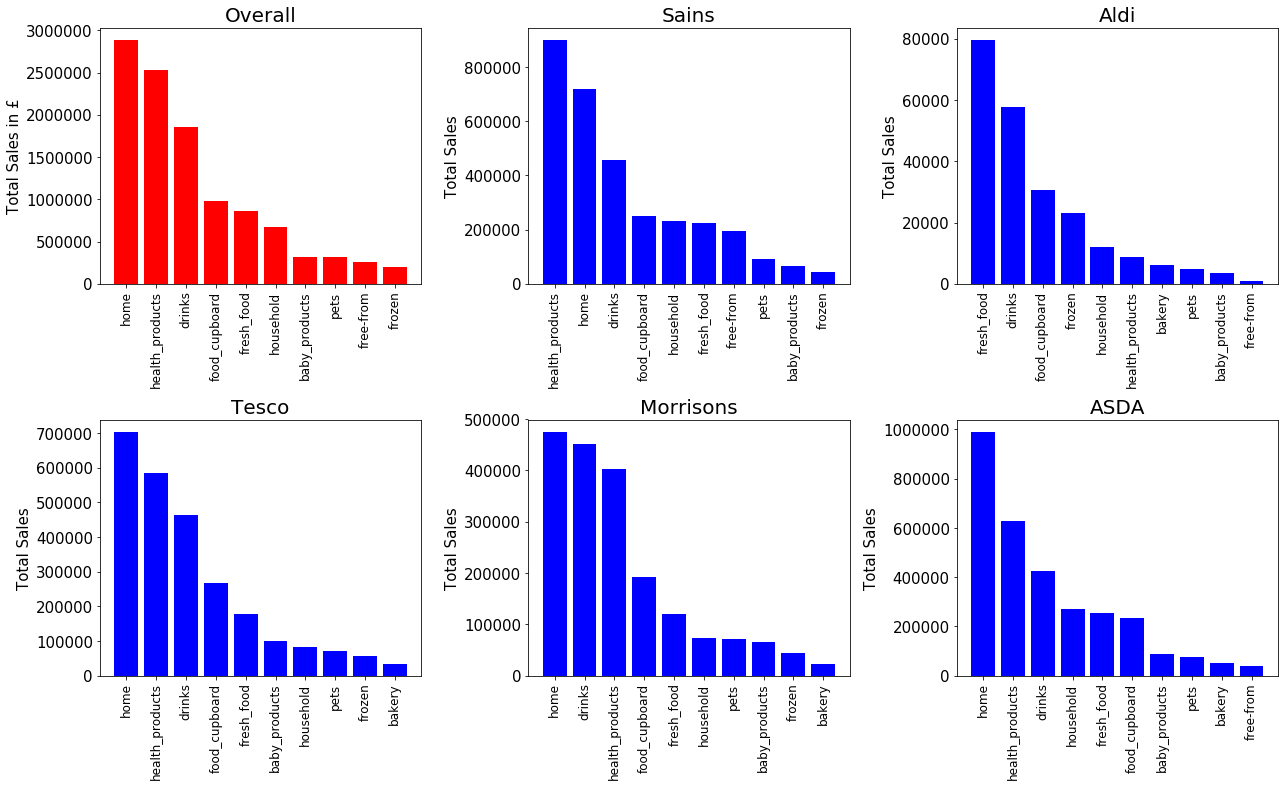

In [16]:
## top 10 types all 

import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import functions as F

# Assuming 'df' is your PySpark DataFrame

# Group by 'product_category' to calculate total sales across all supermarkets for the first plot
total_sales_by_category = df.groupby("product_category").agg(F.sum("price").alias("total_sales"))
top_10_categories = total_sales_by_category.orderBy(F.col("total_sales").desc()).limit(10)
top_10_categories_pd = top_10_categories.toPandas()

# Group by both 'supermarket' and 'product_category' to calculate total sales for the second set of plots
total_sales_by_supermarket_category = df.groupby("supermarket", "product_category").agg(F.sum("price").alias("total_sales"))
supermarkets = df.select("supermarket").distinct().rdd.flatMap(lambda x: x).collect()

# Determine subplot layout
n_supermarkets = len(supermarkets)
n_cols = 3
n_rows = 2  # For 3x2 layout

# Set up the matplotlib figure and axes for the subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 12))

# Plot the overall top 10 in the first subplot
ax_global = axes[0, 0]
ax_global.bar(top_10_categories_pd["product_category"], top_10_categories_pd["total_sales"], color='red', align='center')
ax_global.set_title("Overall", fontsize=20)
ax_global.set_ylabel("Total Sales in £", fontsize=15)
ax_global.tick_params(axis='x', rotation=90, labelsize=12)
ax_global.tick_params(axis='y', labelsize=15)

# Plot top 10 for each supermarket in other subplots
for i, supermarket in enumerate(supermarkets, start=1):
    ax = axes.flatten()[i]
    top_10_categories = total_sales_by_supermarket_category.filter(F.col("supermarket") == supermarket) \
                                                           .orderBy(F.col("total_sales").desc()).limit(10)
    top_10_categories_pd = top_10_categories.toPandas()
    
    ax.bar(top_10_categories_pd["product_category"], top_10_categories_pd["total_sales"], color='blue', align='center')
    ax.set_title(supermarket, fontsize=20)
    ax.set_ylabel("Total Sales", fontsize=15)
    ax.tick_params(axis='x', rotation=90, labelsize=12)
    ax.tick_params(axis='y', labelsize=15)

# Hide unused subplots if there are any
for j in range(i + 1, n_cols * n_rows):
    axes.flatten()[j].set_visible(False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title
plt.show()


In [17]:
from pyspark.sql.functions import sum as sum_, col

# Calculate total sales per product category across all supermarkets for the first plot
total_sales_by_category = df.groupby("product_category").agg(sum_("price").alias("total_sales"))
top_10_categories = total_sales_by_category.orderBy(col("total_sales").desc()).limit(10)
top_10_categories_pd = top_10_categories.toPandas()
print("Top 10 Product Categories Globally:")
print(top_10_categories_pd)
print("\n")

# Calculate total sales per product category for each supermarket for the second set of plots
supermarkets = df.select("supermarket").distinct().rdd.flatMap(lambda x: x).collect()
supermarket_sales_data = {}

for supermarket in supermarkets:
    total_sales_by_supermarket_category = df.filter(df.supermarket == supermarket) \
                                            .groupBy("product_category") \
                                            .agg(sum_("price").alias("total_sales")) \
                                            .orderBy(col("total_sales").desc()).limit(10)
    supermarket_sales_data[supermarket] = total_sales_by_supermarket_category.toPandas()
    print(f"Top 10 Product Categories in {supermarket}:")
    print(supermarket_sales_data[supermarket])
    print("\n")


Top 10 Product Categories Globally:
  product_category   total_sales
0             home  2.888502e+06
1  health_products  2.526759e+06
2           drinks  1.855674e+06
3    food_cupboard  9.750414e+05
4       fresh_food  8.554106e+05
5        household  6.723362e+05
6    baby_products  3.215740e+05
7             pets  3.133146e+05
8        free-from  2.528239e+05
9           frozen  2.008252e+05


Top 10 Product Categories in Sains:
  product_category  total_sales
0  health_products    900081.68
1             home    720051.64
2           drinks    456848.65
3    food_cupboard    251020.09
4        household    229870.04
5       fresh_food    222603.13
6        free-from    195004.16
7             pets     92255.50
8    baby_products     63690.49
9           frozen     43307.22


Top 10 Product Categories in Aldi:
  product_category  total_sales
0       fresh_food     79697.25
1           drinks     57662.30
2    food_cupboard     30544.16
3           frozen     22992.93
4        house

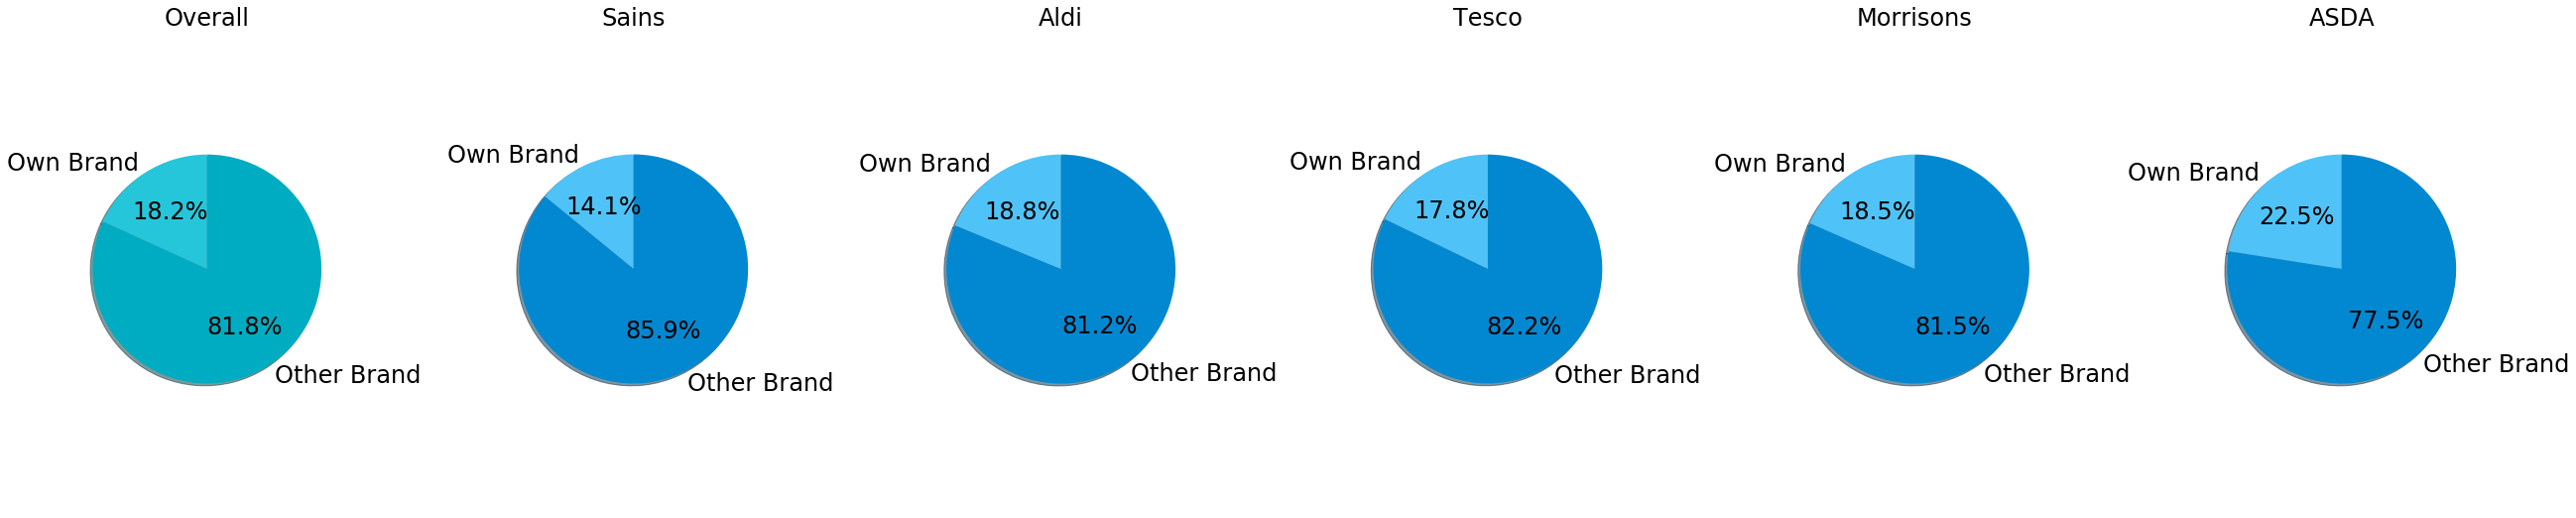

In [48]:
### OWN BRAND VS OTHER BRANDS 6x1
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# Assuming 'df' is your PySpark DataFrame

# Get a list of supermarkets
supermarkets = df.select("supermarket").distinct().rdd.flatMap(lambda x: x).collect()

# Prepare the layout for the subplot
n_supermarkets = len(supermarkets) + 1  # +1 for the overall data
cols = n_supermarkets  # All charts in one row
rows = 1  # Only one row
fig, axs = plt.subplots(rows, cols, figsize=(cols * 6, 8))  # Increased height for better visibility
fig.subplots_adjust(hspace=0.4, wspace=0.2)  # Adjust space between plots

# Colors for the pie charts
overall_colors = ['#26c6da', '#00acc1']  # Distinct colors for the first chart
uniform_colors = ['#4fc3f7', '#0288d1']  # Uniform colors for the supermarket-specific charts

# Plot the overall data first
filtered_df = df.filter(df.own_brand.isNotNull())
sales_by_own_brand = filtered_df.groupBy("own_brand").agg(F.sum("price").alias("total_sales"))
sales_data = sales_by_own_brand.collect()
labels = ['Own Brand' if row['own_brand'] else 'Other Brand' for row in sales_data]
sizes = [row['total_sales'] for row in sales_data]

axs[0].pie(sizes, labels=labels, colors=overall_colors, autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 24})
axs[0].set_title('Overall', fontsize=24)
axs[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Iterate through each supermarket and plot pie chart
for i, supermarket in enumerate(supermarkets, start=1):
    # Filter DataFrame for the current supermarket
    filtered_df = df.filter((df.supermarket == supermarket) & df.own_brand.isNotNull())

    # Aggregate sales by own_brand status
    sales_by_own_brand = filtered_df.groupBy("own_brand").agg(F.sum("price").alias("total_sales"))
    
    # Collect the aggregated data
    sales_data = sales_by_own_brand.collect()

    # Prepare data for the pie chart
    labels = ['Own Brand' if row['own_brand'] else 'Other Brand' for row in sales_data]
    sizes = [row['total_sales'] for row in sales_data]

    # Get current subplot
    axs[i].pie(sizes, labels=labels, colors=uniform_colors, autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 24})
    axs[i].set_title(supermarket, fontsize=24)
    axs[i].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title
plt.show()


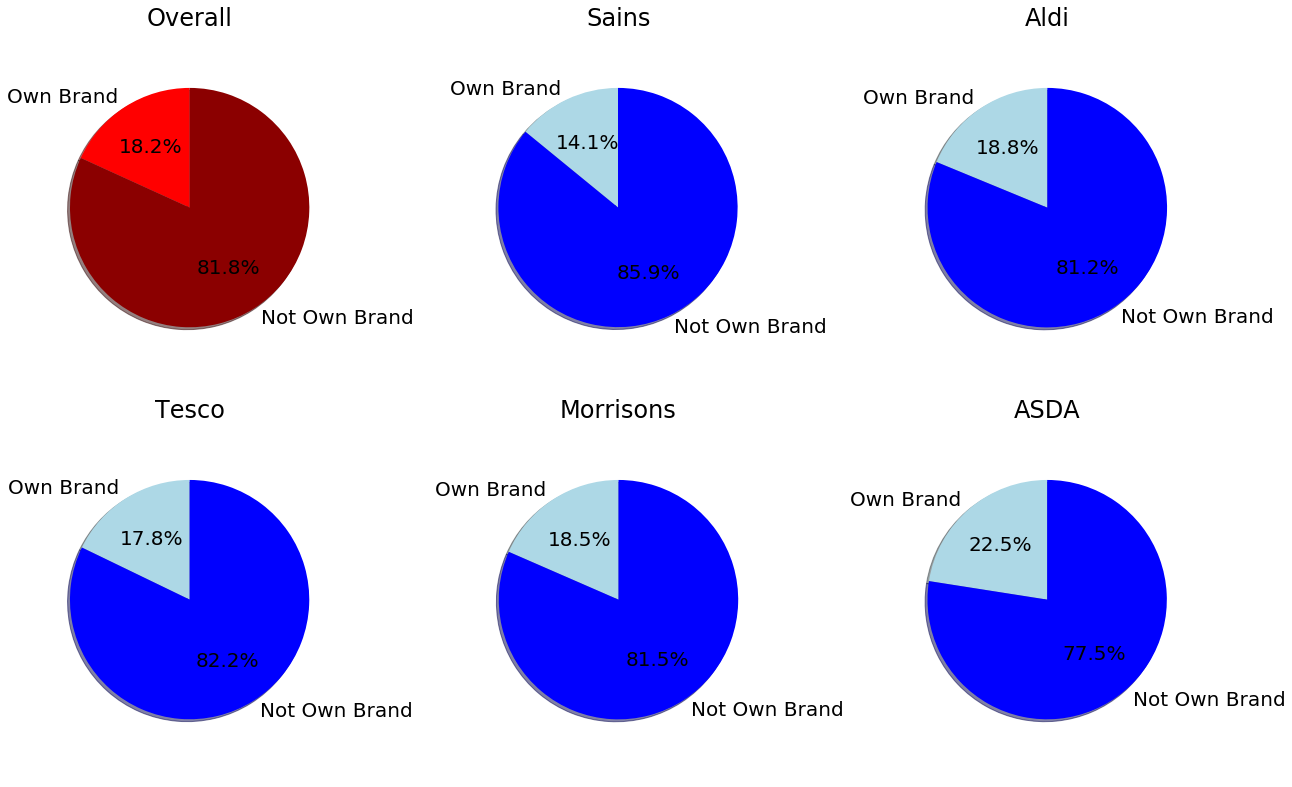

In [54]:
### OWN BRAND VS OTHER BRANDS 3x2
from pyspark.sql.functions import sum as sum_, col
import matplotlib.pyplot as plt

# Assuming 'df' is your PySpark DataFrame

# Calculate total sales and percentages for overall data and each supermarket
filtered_df = df.filter(df.own_brand.isNotNull())
sales_by_own_brand = filtered_df.groupBy("own_brand").agg(F.sum("price").alias("total_sales"))
total_global_sales = sales_by_own_brand.groupBy().sum("total_sales").collect()[0][0]  # Sum of all sales

# Prepare layout for the subplot
supermarkets = df.select("supermarket").distinct().rdd.flatMap(lambda x: x).collect()
n_supermarkets = len(supermarkets) + 1  # +1 for the overall data
fig, axs = plt.subplots(2, 3, figsize=(18, 12))  # 2 rows, 3 columns
fig.subplots_adjust(hspace=0.4, wspace=0.2)  # Adjust space between plots

# Plot the overall data in the first subplot
sales_data = sales_by_own_brand.collect()
sizes = [row['total_sales'] for row in sales_data]
labels = ['Own Brand' if row['own_brand'] else 'Not Own Brand' for row in sales_data]
colors = ['red', 'darkred']  # Distinct colors for the first chart

axs[0, 0].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90,textprops={'fontsize': 20})
axs[0, 0].set_title('Overall', fontsize=24)
axs[0, 0].axis('equal')  # Ensure the pie chart is a circle

# Plot pie charts for each supermarket
for i, supermarket in enumerate(supermarkets, start=1):
    filtered_df = df.filter((df.supermarket == supermarket) & df.own_brand.isNotNull())
    sales_by_own_brand = filtered_df.groupBy("own_brand").agg(F.sum("price").alias("total_sales"))
    total_supermarket_sales = sales_by_own_brand.groupBy().sum("total_sales").collect()[0][0]
    sales_data = sales_by_own_brand.collect()

    sizes = [row['total_sales'] for row in sales_data]
    labels = ['Own Brand' if row['own_brand'] else 'Not Own Brand' for row in sales_data]
    colors = ['lightblue', 'blue']  # Colors for supermarket charts

    row, col = divmod(i, 3)
    axs[row, col].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90,textprops={'fontsize': 20})
    axs[row, col].set_title(supermarket, fontsize=24)
    axs[row, col].axis('equal')

# Hide any unused subplots if the number of supermarkets + 1 is less than 6
for j in range(i + 1, 6):
    axs.flatten()[j].set_visible(False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title
plt.show()


In [26]:
from pyspark.sql.functions import sum as sum_, col

# Calculate the total sales and percentage for overall data
filtered_df = df.filter(df.own_brand.isNotNull())
sales_by_own_brand = filtered_df.groupBy("own_brand").agg(F.sum("price").alias("total_sales"))
total_global_sales = sales_by_own_brand.groupBy().sum("total_sales").collect()[0][0]  # Sum of all sales

sales_data = sales_by_own_brand.collect()
for row in sales_data:
    percentage = (row['total_sales'] / total_global_sales) * 100
    print(f"{'Own Brand' if row['own_brand'] else 'Not Own Brand'}: £{row['total_sales']:.2f}, {percentage:.2f}%")
print("\n")

# Calculate total sales and percentages for each supermarket
supermarkets = df.select("supermarket").distinct().rdd.flatMap(lambda x: x).collect()

for supermarket in supermarkets:
    filtered_df = df.filter((df.supermarket == supermarket) & df.own_brand.isNotNull())
    sales_by_own_brand = filtered_df.groupBy("own_brand").agg(F.sum("price").alias("total_sales"))
    total_supermarket_sales = sales_by_own_brand.groupBy().sum("total_sales").collect()[0][0]  # Sum of all sales in supermarket

    sales_data = sales_by_own_brand.collect()
    print(f"Sales by Own Brand vs Not Own Brand in {supermarket}:")
    for row in sales_data:
        percentage = (row['total_sales'] / total_supermarket_sales) * 100
        print(f"{'Own Brand' if row['own_brand'] else 'Not Own Brand'}: £{row['total_sales']:.2f}, {percentage:.2f}%")
    print("\n")


Overall Sales by Own Brand vs Not Own Brand:
Own Brand: £2002001.38, 18.19%
Not Own Brand: £9002634.58, 81.81%


Sales by Own Brand vs Not Own Brand in Sains:
Own Brand: £450889.37, 14.09%
Not Own Brand: £2750053.07, 85.91%


Sales by Own Brand vs Not Own Brand in Aldi:
Own Brand: £42614.43, 18.78%
Not Own Brand: £184301.11, 81.22%


Sales by Own Brand vs Not Own Brand in Tesco:
Own Brand: £453147.93, 17.83%
Not Own Brand: £2088092.26, 82.17%


Sales by Own Brand vs Not Own Brand in Morrisons:
Own Brand: £357885.24, 18.46%
Not Own Brand: £1580896.70, 81.54%


Sales by Own Brand vs Not Own Brand in ASDA:
Own Brand: £697464.41, 22.52%
Not Own Brand: £2399291.44, 77.48%




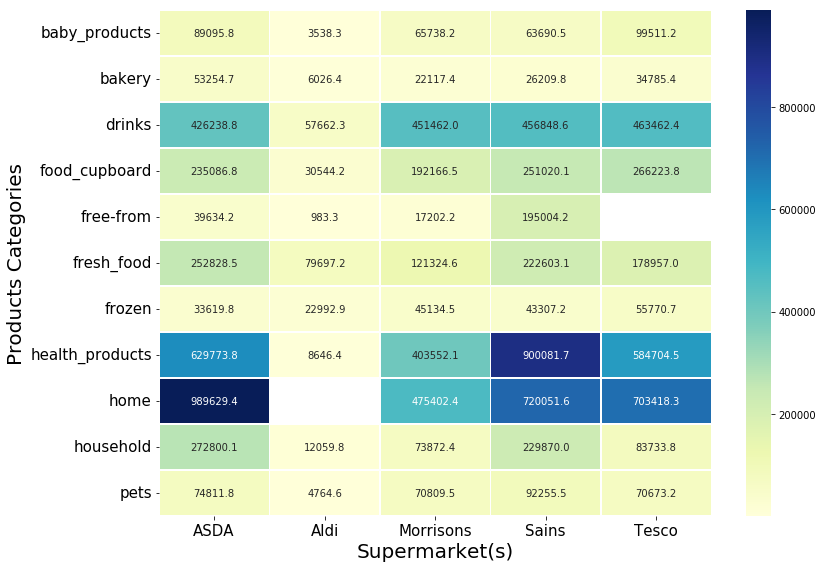

In [32]:
##Sales Volume Heatmap by Supermarkets and Product Category

# Aggregate sales by supermarket and product category
sales_volume = df.groupBy("supermarket", "product_category").agg(F.sum("price").alias("total_sales"))

# Convert to Pandas DataFrame for plotting
sales_volume_pd = sales_volume.toPandas()

# Pivot the DataFrame for the heatmap, swapping the axes
sales_volume_heatmap_data = sales_volume_pd.pivot("product_category", "supermarket", "total_sales")

# Plotting the heatmap
plt.figure(figsize=(12,8))
sns.heatmap(sales_volume_heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=.5)
plt.xlabel("Supermarket(s)", fontsize=20)  # Adjust fontsize as needed
plt.ylabel("Products Categories", fontsize=20)
plt.xticks(rotation=0, ha="center",fontsize=15)
plt.yticks(rotation=0,va="center",fontsize=15)
plt.tight_layout()

plt.show()

In [29]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum as sum_

# Assuming 'df' is your PySpark DataFrame
# Aggregate sales by supermarket and product category
sales_volume = df.groupBy("supermarket", "product_category").agg(sum_("price").alias("total_sales"))

# Convert to Pandas DataFrame for analysis
sales_volume_pd = sales_volume.toPandas()

# Pivot the DataFrame to create a format suitable for a heatmap
sales_volume_heatmap_data = sales_volume_pd.pivot(index="product_category", columns="supermarket", values="total_sales")

# Fill NaN with zeros if any, since heatmaps do not handle NaN values well
sales_volume_heatmap_data.fillna(0, inplace=True)

# Print the heatmap data
print("Sales Volume Heatmap Data by Product Category and Supermarket:")
print(sales_volume_heatmap_data)

# Optionally, print the data in a more structured text format for each product category across each supermarket
print("\nStructured Sales Volume Data:")
for index, row in sales_volume_heatmap_data.iterrows():
    print(f"Product Category: {index}")
    for col in sales_volume_heatmap_data.columns:
        print(f"{col}: £{row[col]:,.2f}")
    print("\n")

Sales Volume Heatmap Data by Product Category and Supermarket:
supermarket            ASDA      Aldi  Morrisons      Sains      Tesco
product_category                                                      
baby_products      89095.81   3538.31   65738.18   63690.49   99511.24
bakery             53254.74   6026.43   22117.42   26209.84   34785.41
drinks            426238.82  57662.30  451462.02  456848.65  463462.35
food_cupboard     235086.84  30544.16  192166.53  251020.09  266223.77
free-from          39634.19    983.29   17202.22  195004.16       0.00
fresh_food        252828.51  79697.25  121324.64  222603.13  178957.04
frozen             33619.84  22992.93   45134.48   43307.22   55770.71
health_products   629773.82   8646.45  403552.10  900081.68  584704.46
home              989629.43      0.00  475402.40  720051.64  703418.27
household         272800.09  12059.84   73872.44  229870.04   83733.78
pets               74811.82   4764.58   70809.51   92255.50   70673.16

Structured Sa

In [49]:
import os
import pandas as pd

def process_csv(file_path):
    try:
        df = pd.read_csv(file_path)
        file_size = os.path.getsize(file_path)
        row_count = len(df)
        print(f"File: {file_path}, Size: {file_size} bytes, Rows: {row_count}")
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

def load_csvs_from_folder(folder_path):
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".csv"):
                file_path = os.path.join(root, file)
                process_csv(file_path)

load_csvs_from_folder('data')


File: data/All_Data_Aldi.csv, Size: 9195647 bytes, Rows: 104055


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3291: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


File: data/All_Data_ASDA.csv, Size: 46093850 bytes, Rows: 538736
File: data/All_Data_Sains.csv, Size: 54107644 bytes, Rows: 591406
File: data/All_Data_Morrisons.csv, Size: 31444802 bytes, Rows: 380933
File: data/All_Data_Tesco.csv, Size: 41461598 bytes, Rows: 489207
